In [1]:
# bibliotecas matetmáticas
import math
import pandas as pd
import numpy as np

# bibliotecas para uso de redes neurais. Neste caso, do tipo LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# bibliotecas para o pré-processamento dos dados. Normalização, etc...
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.signal import savgol_filter
import datetime
from functools import reduce

# bibliotecas para representação dos dados em gráficos
import plotly.offline as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt

import math

Leitura do dataset referente ao período de 8:05 até 8:20 da manhã do NGSIM us-101. São lidas as 100 mil primeiras linhas.

In [2]:
#Leitura dos 100 mil primeiros registros do conjunto de dados

#df = pd.read_csv('NGSIM.csv', nrows=100000)
#df = pd.read_csv('us-101-vehicle-trajectory-data/vehicle-trajectory-data/0750am-0805am/trajectories-0750am-0805am.csv', nrows=100000)
df = pd.read_csv('us-101-vehicle-trajectory-data/vehicle-trajectory-data/0805am-0820am/trajectories-0805am-0820am.csv', nrows=100000)

In [48]:
df.head()

,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_Length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Preceeding,Following,Space_Hdwy,Time_Hdwy
0,1,270,569,1118847869000,51.164,112.878,6451136.708,1873294.084,47.0,8.5,3,19.89,0.00,5,0,0,0.0,0.0
1,1,271,569,1118847869100,51.153,114.878,6451138.053,1873292.603,47.0,8.5,3,19.89,0.00,5,0,0,0.0,0.0
2,1,272,569,1118847869200,51.143,116.878,6451139.397,1873291.122,47.0,8.5,3,19.89,0.00,5,0,0,0.0,0.0
3,1,273,569,1118847869300,51.244,118.815,6451140.617,1873289.614,47.0,8.5,3,19.89,0.00,5,0,0,0.0,0.0
4,1,274,569,1118847869400,51.234,120.814,6451141.961,1873288.133,47.0,8.5,3,19.89,1.07,5,0,0,0.0,0.0


In [78]:
df.tail()

,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_Length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Preceeding,Following,Space_Hdwy,Time_Hdwy
99995,180,1201,528,1118847962100,30.579,524.995,6451446.851,1873016.129,15.0,6.9,2,41.03,-3.95,3,177,184,54.44,1.33
99996,180,1202,528,1118847962200,30.517,529.096,6451449.928,1873013.377,15.0,6.9,2,40.46,-7.39,3,177,184,54.33,1.34
99997,180,1203,528,1118847962300,30.455,533.083,6451453.005,1873010.625,15.0,6.9,2,40.08,-3.25,3,177,184,54.33,1.36
99998,180,1204,528,1118847962400,30.448,537.036,6451456.081,1873007.874,15.0,6.9,2,40.08,3.52,3,177,184,54.39,1.36
99999,180,1205,528,1118847962500,30.448,541.042,6451459.158,1873005.122,15.0,6.9,2,40.34,5.16,3,177,184,54.45,1.35


Conversão das posições lateral (Local_X) e longitudinal (Local_Y) dos veículos do dataframe de pés para metros.

In [3]:
local_x_len = len(df['Local_X'])
local_y_len = len(df['Local_X'])

local_x = []
local_y = []
for row in df.itertuples():
    local_x.append(row.Local_X / 3.2808)
    local_y.append(row.Local_Y / 3.2808)

df['Local_X_meters'] = pd.Series(local_x, index=df.index)
df['Local_Y_meters'] = pd.Series(local_y, index=df.index)

In [4]:
df.head()

,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_Length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Preceeding,Following,Space_Hdwy,Time_Hdwy,Local_X_meters,Local_Y_meters
0,1,270,569,1118847869000,51.164,112.878,6451136.708,1873294.084,47.0,8.5,3,19.89,0.00,5,0,0,0.0,0.0,15.594977,34.405633
1,1,271,569,1118847869100,51.153,114.878,6451138.053,1873292.603,47.0,8.5,3,19.89,0.00,5,0,0,0.0,0.0,15.591624,35.015240
2,1,272,569,1118847869200,51.143,116.878,6451139.397,1873291.122,47.0,8.5,3,19.89,0.00,5,0,0,0.0,0.0,15.588576,35.624848
3,1,273,569,1118847869300,51.244,118.815,6451140.617,1873289.614,47.0,8.5,3,19.89,0.00,5,0,0,0.0,0.0,15.619361,36.215252
4,1,274,569,1118847869400,51.234,120.814,6451141.961,1873288.133,47.0,8.5,3,19.89,1.07,5,0,0,0.0,0.0,15.616313,36.824555


In [68]:
df.tail()

,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_Length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Preceeding,Following,Space_Hdwy,Time_Hdwy,Local_X_meters,Local_Y_meters
99995,180,1201,528,1118847962100,30.579,524.995,6451446.851,1873016.129,15.0,6.9,2,41.03,-3.95,3,177,184,54.44,1.33,9.320593,160.020422
99996,180,1202,528,1118847962200,30.517,529.096,6451449.928,1873013.377,15.0,6.9,2,40.46,-7.39,3,177,184,54.33,1.34,9.301695,161.270422
99997,180,1203,528,1118847962300,30.455,533.083,6451453.005,1873010.625,15.0,6.9,2,40.08,-3.25,3,177,184,54.33,1.36,9.282797,162.485674
99998,180,1204,528,1118847962400,30.448,537.036,6451456.081,1873007.874,15.0,6.9,2,40.08,3.52,3,177,184,54.39,1.36,9.280663,163.690563
99999,180,1205,528,1118847962500,30.448,541.042,6451459.158,1873005.122,15.0,6.9,2,40.34,5.16,3,177,184,54.45,1.35,9.280663,164.911607


In [4]:
len(df)

100000

Todas as colunas do NGSIM us-101:

In [5]:
df.columns

Index(['Vehicle_ID', 'Frame_ID', 'Total_Frames', 'Global_Time', 'Local_X',
       'Local_Y', 'Global_X', 'Global_Y', 'v_Length', 'v_Width', 'v_Class',
       'v_Vel', 'v_Acc', 'Lane_ID', 'Preceeding', 'Following', 'Space_Hdwy',
       'Time_Hdwy', 'Local_X_meters', 'Local_Y_meters'],
      dtype='object')

Métodos __get_vehicle_dataset()__ para gerar um _DataFrame_ com todas as linhas de um veículo específico e __get_surround_dataset_from_same_frames_of_target()__ para gerar um dataset de acordo com os _frames_ em que aparece com o veículo alvo.

Os parâmentros para _get_vehicle_dataset()_ são:
* __full_df__: dataset que contém todas os dados completos
* __vehicle_id__: ID do veículo principal que o _DataFrame_ gerado se refere
* __position__: qual o campo que o _vehicle_id_ será comparado durante a busca. Pode ser _Vehicle_ID_, _Preceeding_ ou _Following_.

Os parâmentros para _get_surround_dataset_from_same_frames_of_target()_ são:
* __target_df__: dataset com as informações do veículo alvo para comparar os frames desejados
* __surround_df__: dataset dos veículos em algumas das posições ao redor selecionadas

In [6]:
# Criação de dataframe com informações do veículo de interesse
def get_target_dataframe(full_df, vehicle_id):
    target_df = pd.DataFrame(columns=['Vehicle_ID',
                                      'Frame_ID', 
                                      'Global_Time', 
                                      'Local_X',
                                      'Local_Y',
                                      'Local_X_meters',
                                      'Local_Y_meters',
                                      'v_Vel',
                                      'v_Class',
                                      'Preceeding',
                                      'Following'])

    for row in full_df.itertuples():
        if row.Vehicle_ID == vehicle_id:
            target_df = target_df.append({'Vehicle_ID': row.Vehicle_ID,
                                          'Frame_ID': row.Frame_ID,
                                          'Global_Time': row.Global_Time,
                                          'Local_X': row.Local_X,
                                          'Local_Y': row.Local_Y,
                                          'Local_X_meters': row.Local_X_meters,
                                          'Local_Y_meters': row.Local_Y_meters,
                                          'v_Vel': row.v_Vel,
                                          'v_Class': row.v_Class,
                                          'Preceeding': row.Preceeding,
                                          'Following': row.Following}, ignore_index=True)

    target_df = target_df.astype({'Vehicle_ID': 'int',
                                  'Frame_ID': 'int',
                                  'Global_Time': 'int',
                                  'v_Class': 'int',
                                  'Preceeding': 'int',
                                  'Following': 'int'})

    return target_df

def get_preceeding_or_following_dataframe(full_df, target_df, position="preceeding"):
    final_df = pd.DataFrame(columns=['Vehicle_ID',
                                      'Frame_ID', 
                                      'Global_Time', 
                                      'Local_X',
                                      'Local_Y',
                                      'Local_X_meters',
                                      'Local_Y_meters',
                                      'v_Vel',
                                      'v_Class',
                                      'Preceeding',
                                      'Following'])

    for row in full_df.itertuples():
        for line in target_df.itertuples():
            if row.Frame_ID == line.Frame_ID:
                if position == "preceeding" and row.Preceeding == line.Vehicle_ID:
                    final_df = final_df.append({'Vehicle_ID': row.Vehicle_ID,
                                                  'Frame_ID': row.Frame_ID,
                                                  'Global_Time': row.Global_Time,
                                                  'Local_X': row.Local_X,
                                                  'Local_Y': row.Local_Y,
                                                  'Local_X_meters': row.Local_X_meters,
                                                  'Local_Y_meters': row.Local_Y_meters,
                                                  'v_Vel': row.v_Vel,
                                                  'v_Class': row.v_Class,
                                                  'Preceeding': row.Preceeding,
                                                  'Following': row.Following}, ignore_index=True)
                    break
                elif position == "following" and row.Following == line.Vehicle_ID:
                    final_df = final_df.append({'Vehicle_ID': row.Vehicle_ID,
                                                  'Frame_ID': row.Frame_ID,
                                                  'Global_Time': row.Global_Time,
                                                  'Local_X': row.Local_X,
                                                  'Local_Y': row.Local_Y,
                                                  'Local_X_meters': row.Local_X_meters,
                                                  'Local_Y_meters': row.Local_Y_meters,
                                                  'v_Vel': row.v_Vel,
                                                  'v_Class': row.v_Class,
                                                  'Preceeding': row.Preceeding,
                                                  'Following': row.Following}, ignore_index=True)
                    break

    final_df = final_df.astype({'Vehicle_ID': 'int',
                                  'Frame_ID': 'int',
                                  'Global_Time': 'int',
                                  'v_Class': 'int',
                                  'Preceeding': 'int',
                                  'Following': 'int'})

    return final_df

# Criação de dataframe com informações dos veículos ao redor
def get_surround_dataframe_from_same_frames_of_target(target_df, surround_df):
    final_df = pd.DataFrame(columns=['Vehicle_ID',
                                      'Frame_ID', 
                                      'Global_Time', 
                                      'Local_X',
                                      'Local_Y',
                                      'v_Vel',
                                      'v_Class',
                                      'Preceeding',
                                      'Following'])

    for index, row in surround_df.iterrows():
        for i, line in target_df.iterrows():
            if row['Frame_ID'] == line['Frame_ID']:
                final_df = final_df.append({'Vehicle_ID': row['Vehicle_ID'],
                                              'Frame_ID': row['Frame_ID'],
                                              'Global_Time': row['Global_Time'],
                                              'Local_X': row['Local_X'],
                                              'Local_Y': row['Local_Y'],
                                              'v_Vel': row['v_Vel'],
                                              'v_Class': row['v_Class'],
                                              'Preceeding': row['Preceeding'],
                                              'Following': row['Following']}, ignore_index=True)
                break

    final_df = final_df.astype({'Vehicle_ID': 'int',
                                  'Frame_ID': 'int',
                                  'Global_Time': 'int',
                                  'v_Class': 'int',
                                  'Preceeding': 'int',
                                  'Following': 'int'})

    return final_df

Método __application_of_savgol_filter_and_return_dataframe()__ para aplicação do filtro Savitzky-Golay nas colunas Local_X e Local_Y.

Os parâmentros para _application_of_savgol_filter_and_return_dataframe()_ são:
* __actual_df__: dataframe com as informações do veículo que passarão pelo filtro.

In [7]:
def application_of_savgol_filter_and_return_dataframe(actual_df):
    if len(actual_df) == 0:
        return actual_df
    
    local_x = np.array(actual_df['Local_X_meters'])
    local_x_savgol = savgol_filter(local_x, 11, 2)
    
    local_y = np.array(actual_df['Local_Y_meters'])
    local_y_savgol = savgol_filter(local_y, 11, 2)
    
    actual_df['Local_X_filtered'] = pd.Series(local_x_savgol, index=actual_df.index)
    actual_df['Local_Y_filtered'] = pd.Series(local_y_savgol, index=actual_df.index)
        
    return actual_df

In [8]:
full_target_df = get_target_dataframe(df, 16)

Gerando um _DataFrame_ do veículo alvo. São utilizados os últimos 100 frames em que o veículo aparece, o que equivalem à 10 segundos.

In [9]:
initial_target_df = full_target_df[-101:].copy()
target_df = full_target_df[-101:].copy()
target_df.head()

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,Local_X_meters,Local_Y_meters,v_Vel,v_Class,Preceeding,Following
451,16,777,1118847919700,53.031,1608.381,16.164045,490.240490,54.72,2,1,21
452,16,778,1118847919800,52.973,1613.870,16.146367,491.913558,54.28,2,1,21
453,16,779,1118847919900,52.960,1619.293,16.142404,493.566508,53.47,2,1,21
454,16,780,1118847920000,52.943,1624.595,16.137223,495.182577,52.40,2,1,21
455,16,781,1118847920100,52.900,1629.770,16.124116,496.759937,51.34,2,1,21


In [10]:
target_df.tail()

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,Local_X_meters,Local_Y_meters,v_Vel,v_Class,Preceeding,Following
547,16,873,1118847929300,56.091,2139.412,17.096745,652.100707,59.94,2,0,21
548,16,874,1118847929400,56.124,2145.403,17.106803,653.926786,59.94,2,0,21
549,16,875,1118847929500,56.197,2151.395,17.129054,655.753170,59.94,2,0,21
550,16,876,1118847929600,56.192,2157.395,17.127530,657.581992,59.94,2,0,21
551,16,877,1118847929700,56.188,2163.395,17.126311,659.410814,59.94,2,0,21


In [11]:
target_df = application_of_savgol_filter_and_return_dataframe(target_df)
target_df.head()

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,Local_X_meters,Local_Y_meters,v_Vel,v_Class,Preceeding,Following,Local_X_filtered,Local_Y_filtered
451,16,777,1118847919700,53.031,1608.381,16.164045,490.240490,54.72,2,1,21,16.164207,490.278452
452,16,778,1118847919800,52.973,1613.870,16.146367,491.913558,54.28,2,1,21,16.151164,491.917952
453,16,779,1118847919900,52.960,1619.293,16.142404,493.566508,53.47,2,1,21,16.139918,493.539488
454,16,780,1118847920000,52.943,1624.595,16.137223,495.182577,52.40,2,1,21,16.130469,495.143058
455,16,781,1118847920100,52.900,1629.770,16.124116,496.759937,51.34,2,1,21,16.122816,496.728664


In [12]:
target_df.tail()

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,Local_X_meters,Local_Y_meters,v_Vel,v_Class,Preceeding,Following,Local_X_filtered,Local_Y_filtered
547,16,873,1118847929300,56.091,2139.412,17.096745,652.100707,59.94,2,0,21,17.103681,652.093592
548,16,874,1118847929400,56.124,2145.403,17.106803,653.926786,59.94,2,0,21,17.109111,653.921945
549,16,875,1118847929500,56.197,2151.395,17.129054,655.753170,59.94,2,0,21,17.115846,655.751895
550,16,876,1118847929600,56.192,2157.395,17.127530,657.581992,59.94,2,0,21,17.123886,657.583442
551,16,877,1118847929700,56.188,2163.395,17.126311,659.410814,59.94,2,0,21,17.133232,659.416587


Gráfico comparativo entre a posição lateral real e a posição lateral após a aplicação do filtro do veículo alvo.

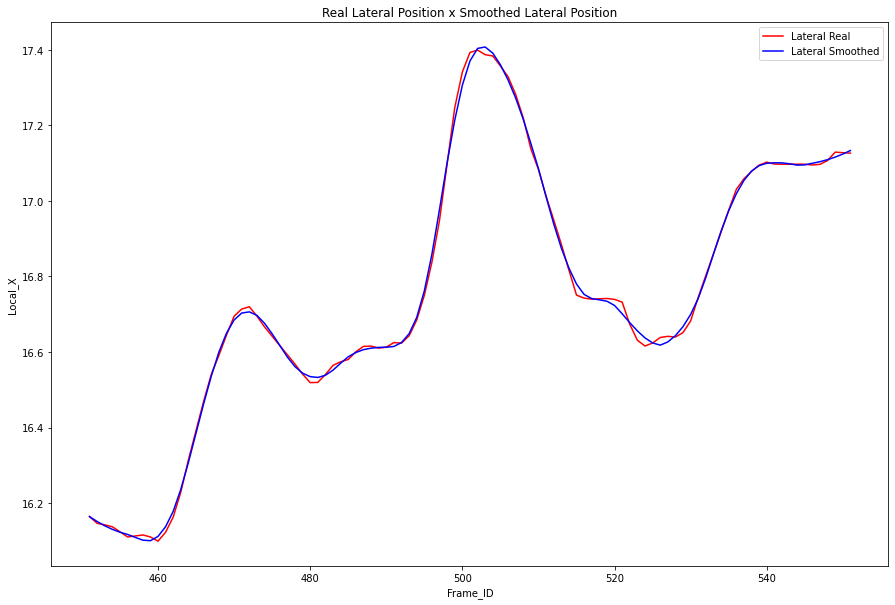

In [13]:
plt.figure(figsize=(15, 10))
line_red, = plt.plot(initial_target_df['Local_X_meters'], color='red', label='Lateral Real')
line_blue, = plt.plot(target_df['Local_X_filtered'], color='blue', label='Lateral Smoothed')
plt.title('Real Lateral Position x Smoothed Lateral Position')
plt.xlabel('Frame_ID')
plt.ylabel('Local_X')
plt.legend(handles=[line_red, line_blue])

Gerando um _DataFrame_ do veículo atrás do veículo alvo.

In [14]:
behind_df = get_preceeding_or_following_dataframe(df, target_df)
#behind_df = get_vehicle_dataset(m_df, 16, "Preceeding")
#behind_df = get_surround_dataset_from_same_frames_of_target(target_df, behind_df)
behind_df = application_of_savgol_filter_and_return_dataframe(behind_df)
behind_df.head()

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,Local_X_meters,Local_Y_meters,v_Vel,v_Class,Preceeding,Following,Local_X_filtered,Local_Y_filtered
0,21,777,1118847919700,55.673,1474.827,16.969337,449.532736,50.16,2,16,25,16.969326,449.530562
1,21,778,1118847919800,55.663,1479.810,16.966289,451.051573,50.00,2,16,25,16.966296,451.053529
2,21,779,1118847919900,55.653,1484.810,16.963241,452.575591,50.00,2,16,25,16.963273,452.576678
3,21,780,1118847920000,55.643,1489.810,16.960193,454.099610,50.00,2,16,25,16.960258,454.100008
4,21,781,1118847920100,55.634,1494.810,16.957449,455.623628,50.00,2,16,25,16.957251,455.623520


In [15]:
behind_df.tail()

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,Local_X_meters,Local_Y_meters,v_Vel,v_Class,Preceeding,Following,Local_X_filtered,Local_Y_filtered
96,21,873,1118847929300,54.965,1971.695,16.753536,600.979944,56.64,2,16,25,16.786715,601.015151
97,21,874,1118847929400,55.010,1977.429,16.767252,602.727688,57.12,2,16,25,16.786061,602.737008
98,21,875,1118847929500,55.132,1983.206,16.804438,604.488539,57.02,2,16,25,16.788298,604.464980
99,21,876,1118847929600,55.155,1988.908,16.811448,606.226530,56.44,2,16,25,16.793426,606.199067
100,21,877,1118847929700,55.105,1994.480,16.796208,607.924896,55.99,2,16,25,16.801445,607.939269


Gerando um _DataFrame_ do veículo à frente do veículo alvo.

In [16]:
front_df = get_preceeding_or_following_dataframe(df, target_df, "following")
#front_df = get_vehicle_dataset(m_df, 16, "Following")
#front_df = get_surround_dataset_from_same_frames_of_target(target_df, front_df)
front_df = application_of_savgol_filter_and_return_dataframe(front_df)
front_df.head()

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,Local_X_meters,Local_Y_meters,v_Vel,v_Class,Preceeding,Following,Local_X_filtered,Local_Y_filtered
0,1,777,1118847919700,55.652,1806.934,16.962936,550.760180,55.95,3,0,16,16.972133,550.721519
1,1,778,1118847919800,55.835,1812.519,17.018715,552.462509,56.04,3,0,16,17.018476,552.457358
2,1,779,1118847919900,55.985,1818.115,17.064436,554.168191,56.30,3,0,16,17.057372,554.194077
3,1,780,1118847920000,56.088,1823.736,17.095830,555.881492,56.91,3,0,16,17.088821,555.931677
4,1,781,1118847920100,56.166,1829.467,17.119605,557.628322,57.67,3,0,16,17.112823,557.670156


In [17]:
front_df.tail()

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,Local_X_meters,Local_Y_meters,v_Vel,v_Class,Preceeding,Following,Local_X_filtered,Local_Y_filtered
57,1,834,1118847925400,56.965,2143.216,17.363143,653.260180,59.06,3,0,16,17.358663,653.228823
58,1,835,1118847925500,56.946,2149.061,17.357352,655.041758,58.76,3,0,16,17.357866,655.033339
59,1,836,1118847925600,56.942,2154.789,17.356133,656.787674,58.76,3,0,16,17.356694,656.834163
60,1,837,1118847925700,56.937,2160.789,17.354609,658.616496,58.76,3,0,16,17.355148,658.631294
61,1,838,1118847925800,56.932,2166.789,17.353085,660.445318,58.76,3,0,16,17.353227,660.424732


Gerando um _DataFrame_ do veículo à frente do veículo à frente do alvo.

In [18]:
front_front_df = get_preceeding_or_following_dataframe(df, front_df, "following")
#front_front_df = get_vehicle_dataset(m_df, 1, "Following")
#front_front_df = get_surround_dataset_from_same_frames_of_target(front_df, front_front_df)
front_front_df = application_of_savgol_filter_and_return_dataframe(front_front_df)
front_front_df.head()

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,Local_X_meters,Local_Y_meters,v_Vel,v_Class,Preceeding,Following


Métodos __get_left_or_right_vehicle_dataset()__ para gerar um _DataFrame_ com todas as linhas dos veículos à esquerda ou à direita do veículo alvo.

Os parâmentros para _get_left_or_right_vehicle_dataset()_ são:
* __full_df__: _DataFrame_ que contém todas os dados completos
* __target_df__: _DataFrame_ que contém as informações do veículo alvo
* __side__: qual o lado que os veículos buscados estará em relação ao alvo. Pode ser _Left_ ou _Right_.

In [21]:
# Criação de Dataset com informações dos veículos à esquerda ou à direita do veículo alvo

def get_left_or_right_vehicle_dataset(full_df, target_df, side="left"):
    side_df = pd.DataFrame(columns=['Vehicle_ID',
                                      'Frame_ID', 
                                      'Global_Time', 
                                      'Local_X',
                                      'Local_Y',
                                      'Local_X_meters',
                                      'Local_Y_meters',
                                      'v_Vel',
                                      'v_Class',
                                      'Preceeding',
                                      'Following'])

    for row in full_df.itertuples():
        for line in target_df.itertuples():
            if row.Frame_ID == line.Frame_ID and row.Vehicle_ID != line.Vehicle_ID:
                if side == "left":
                    if row.Local_X < line.Local_X and abs(row.Local_Y_meters - line.Local_Y_meters) < 1:
                        side_df = side_df.append({'Vehicle_ID': row.Vehicle_ID,
                                                  'Frame_ID': row.Frame_ID,
                                                  'Global_Time': row.Global_Time,
                                                  'Local_X': row.Local_X,
                                                  'Local_Y': row.Local_Y,
                                                  'Local_X_meters': row.Local_X_meters,
                                                  'Local_Y_meters': row.Local_Y_meters,
                                                  'v_Vel': row.v_Vel,
                                                  'v_Class': row.v_Class,
                                                  'Preceeding': row.Preceeding,
                                                  'Following': row.Following}, ignore_index=True)
                        break
                elif side == "right":
                    if row.Local_X > line.Local_X and abs(row.Local_Y - line.Local_Y) < 1:
                        side_df = side_df.append({'Vehicle_ID': row.Vehicle_ID,
                                                  'Frame_ID': row.Frame_ID,
                                                  'Global_Time': row.Global_Time,
                                                  'Local_X': row.Local_X,
                                                  'Local_Y': row.Local_Y,
                                                  'Local_X_meters': row.Local_X_meters,
                                                  'Local_Y_meters': row.Local_Y_meters,
                                                  'v_Vel': row.v_Vel,
                                                  'v_Class': row.v_Class,
                                                  'Preceeding': row.Preceeding,
                                                  'Following': row.Following}, ignore_index=True)
                        break
                

    side_df = side_df.astype({'Vehicle_ID': 'int',
                                  'Frame_ID': 'int',
                                  'Global_Time': 'int',
                                  'v_Class': 'int',
                                  'Preceeding': 'int',
                                  'Following': 'int'})

    return side_df

Gerando um _DataFrame_ do veículo à esquerda do veículo alvo.

In [22]:
%%time
left_df = get_left_or_right_vehicle_dataset(df, target_df)
left_df = application_of_savgol_filter_and_return_dataframe(left_df)

CPU times: user 1min 11s, sys: 7.71 ms, total: 1min 11s
Wall time: 1min 11s


In [23]:
left_df.head()

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,Local_X_meters,Local_Y_meters,v_Vel,v_Class,Preceeding,Following,Local_X_filtered,Local_Y_filtered
0,7,812,1118847923200,29.947,1797.699,9.127957,547.945318,50.0,2,3,11,9.125533,547.952836
1,7,813,1118847923300,29.970,1802.699,9.134967,549.469337,50.0,2,3,11,9.134934,549.469118
2,7,814,1118847923400,29.994,1807.698,9.142282,550.993050,50.0,2,3,11,9.143602,550.988190
3,7,815,1118847923500,30.018,1812.698,9.149598,552.517069,50.0,2,3,11,9.151537,552.510050
4,7,816,1118847923600,30.041,1817.698,9.156608,554.041088,50.0,2,3,11,9.158738,554.034698


In [24]:
left_df.tail()

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,Local_X_meters,Local_Y_meters,v_Vel,v_Class,Preceeding,Following,Local_X_filtered,Local_Y_filtered
17,7,829,1118847924900,30.014,1883.428,9.148378,574.075835,53.61,2,3,11,9.151849,574.089453
18,7,830,1118847925000,30.045,1888.866,9.157827,575.733358,54.47,2,3,11,9.150897,575.728742
19,7,831,1118847925100,30.027,1894.363,9.152341,577.408864,55.05,2,3,11,9.151190,577.393799
20,7,832,1118847925200,30.016,1899.891,9.148988,579.093819,55.53,2,3,11,9.152726,579.084624
21,7,833,1118847925300,30.044,1905.461,9.157523,580.791575,56.03,2,3,11,9.155506,580.801216


Gerando um _DataFrame_ do veículo atrás do veículo à esquerda do alvo.

In [25]:
behind_left_df = get_preceeding_or_following_dataframe(df, left_df)
#behind_left_df = get_vehicle_dataset(m_df, 7, "Preceeding")
#behind_left_df = get_surround_dataset_from_same_frames_of_target(left_df, behind_left_df)
behind_left_df = application_of_savgol_filter_and_return_dataframe(behind_left_df)
behind_left_df.head()

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,Local_X_meters,Local_Y_meters,v_Vel,v_Class,Preceeding,Following,Local_X_filtered,Local_Y_filtered
0,11,812,1118847923200,31.298,1731.328,9.539746,527.715191,50.00,2,7,15,9.549931,527.720671
1,11,813,1118847923300,31.220,1736.328,9.515972,529.239210,50.00,2,7,15,9.515324,529.248202
2,11,814,1118847923400,31.143,1741.328,9.492502,530.763228,50.00,2,7,15,9.485064,530.769556
3,11,815,1118847923500,31.065,1746.327,9.468727,532.286942,49.99,2,7,15,9.459150,532.284734
4,11,816,1118847923600,30.988,1751.363,9.445257,533.821934,49.66,2,7,15,9.437584,533.793735


In [26]:
behind_left_df.tail()

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,Local_X_meters,Local_Y_meters,v_Vel,v_Class,Preceeding,Following,Local_X_filtered,Local_Y_filtered
17,11,829,1118847924900,31.026,1815.702,9.456840,553.432699,50.00,2,7,15,9.456726,553.431658
18,11,830,1118847925000,31.049,1820.702,9.463850,554.956718,50.00,2,7,15,9.463926,554.957457
19,11,831,1118847925100,31.073,1825.690,9.471166,556.477079,50.11,2,7,15,9.471112,556.483939
20,11,832,1118847925200,31.096,1830.701,9.478176,558.004450,50.37,2,7,15,9.478283,558.011104
21,11,833,1118847925300,31.120,1835.764,9.485491,559.547671,50.55,2,7,15,9.485440,559.538951


Gerando um _DataFrame_ do veículo à frente do veículo à esquerda do alvo.

In [27]:
front_left_df = get_preceeding_or_following_dataframe(df, front_df, "following")
#front_left_df = get_vehicle_dataset(m_df, 7, "Following")
#front_left_df = get_surround_dataset_from_same_frames_of_target(left_df, front_left_df)
front_left_df = application_of_savgol_filter_and_return_dataframe(front_left_df)
front_left_df.head()

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,Local_X_meters,Local_Y_meters,v_Vel,v_Class,Preceeding,Following


In [28]:
front_left_df.tail()

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,Local_X_meters,Local_Y_meters,v_Vel,v_Class,Preceeding,Following


Gerando um _DataFrame_ do veículo à direita do veículo alvo.

In [29]:
%%time
right_df = get_left_or_right_vehicle_dataset(df, target_df, 'right')
right_df = application_of_savgol_filter_and_return_dataframe(right_df)

CPU times: user 1min 21s, sys: 23.8 ms, total: 1min 21s
Wall time: 1min 21s


In [30]:
right_df.head()

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,Local_X_meters,Local_Y_meters,v_Vel,v_Class,Preceeding,Following


Gerando um _DataFrame_ do veículo atrás do veículo à direita do alvo.

In [32]:
behind_right_df = get_preceeding_or_following_dataframe(df, right_df)
#behind_right_df = get_vehicle_dataset(m_df, -1, "Preceeding")
#behind_right_df = get_surround_dataset_from_same_frames_of_target(right_df, behind_right_df)
behind_right_df = application_of_savgol_filter_and_return_dataframe(behind_right_df)
behind_right_df.head()

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,Local_X_meters,Local_Y_meters,v_Vel,v_Class,Preceeding,Following


Gerando um _DataFrame_ do veículo à frente do veículo à direita do alvo.

In [33]:
front_right_df = get_preceeding_or_following_dataframe(df, right_df, "following")
#front_right_df = get_vehicle_dataset(m_df, -1, "Following")
#front_right_df = get_surround_dataset_from_same_frames_of_target(right_df, front_right_df)
front_right_df = application_of_savgol_filter_and_return_dataframe(front_right_df)
front_right_df.head()

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,Local_X_meters,Local_Y_meters,v_Vel,v_Class,Preceeding,Following


Adição de sufixos às colunas dos _DataFrames_ gerados para indentificação após o _merge_. Os sufixos são:
* __target_df:__ targ
* __behind_df:__ b
* __front_df:__ f
* __front_front_df:__ ff
* __left_df:__ l
* __behind_left_df:__ bl
* __front_left_df:__ fl
* __right_df:__ r
* __behind_right_df:__ br
* __front_right_df:__ fr

In [47]:
s_target_df = target_df.copy()
s_behind_df = behind_df.copy()
s_front_df = front_df.copy()
s_front_front_df = front_front_df.copy()
s_left_df = left_df.copy()
s_behind_left_df = behind_left_df.copy()
s_front_left_df = front_left_df.copy()
s_right_df = right_df.copy()
s_behind_right_df= behind_right_df.copy()
s_front_right_df = front_right_df.copy()

In [35]:
def get_final_target_dataframe(target_df, start_index):
    new_df = pd.DataFrame(columns=['Vehicle_ID', 
                                   'Frame_ID',
                                   'Global_Time',
                                   'Local_X',
                                   'Local_Y',
                                   'Local_X_meters',
                                   'Local_Y_meters',
                                   'Local_X_Vel',
                                   'Local_Y_Vel',
                                   'v_Class'])
    
    for row in target_df.itertuples():
        if row.Index > start_index:
            time = (row.Global_Time - target_df['Global_Time'][row.Index-1]) / 1000
            local_x_vel = (row.Local_X_meters - target_df['Local_X_meters'][row.Index-1]) / time
            local_y_vel = (row.Local_Y_meters - target_df['Local_Y_meters'][row.Index-1]) / time
            new_df = new_df.append({'Vehicle_ID': row.Vehicle_ID,
                                       'Frame_ID': row.Frame_ID,
                                       'Global_Time': row.Global_Time,
                                       'Local_X': row.Local_X,
                                       'Local_Y': row.Local_Y,
                                       'Local_X_meters': row.Local_X_meters,
                                       'Local_Y_meters': row.Local_Y_meters,
                                       'Local_X_Vel': local_x_vel,
                                       'Local_Y_Vel': local_y_vel,
                                       'v_Class': row.v_Class}, ignore_index=True)
        
    new_df = new_df.astype({'Vehicle_ID': 'int', 
                            'Frame_ID': 'int',
                            'Global_Time': 'int',
                            'v_Class': 'int'})
        
    return new_df

In [48]:
s_target_df = get_final_target_dataframe(s_target_df, s_target_df.index.start)
s_target_df.head()

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,Local_X_meters,Local_Y_meters,Local_X_Vel,Local_Y_Vel,v_Class
0,16,778,1118847919800,52.973,1613.870,16.146367,491.913558,-0.176786,16.730675,2
1,16,779,1118847919900,52.960,1619.293,16.142404,493.566508,-0.039624,16.529505,2
2,16,780,1118847920000,52.943,1624.595,16.137223,495.182577,-0.051817,16.160693,2
3,16,781,1118847920100,52.900,1629.770,16.124116,496.759937,-0.131066,15.773592,2
4,16,782,1118847920200,52.855,1634.832,16.110400,498.302853,-0.137162,15.429164,2


In [49]:
s_target_df.tail()

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,Local_X_meters,Local_Y_meters,Local_X_Vel,Local_Y_Vel,v_Class
95,16,873,1118847929300,56.091,2139.412,17.096745,652.100707,0.018288,18.266886,2
96,16,874,1118847929400,56.124,2145.403,17.106803,653.926786,0.100585,18.260790,2
97,16,875,1118847929500,56.197,2151.395,17.129054,655.753170,0.222507,18.263838,2
98,16,876,1118847929600,56.192,2157.395,17.127530,657.581992,-0.015240,18.288222,2
99,16,877,1118847929700,56.188,2163.395,17.126311,659.410814,-0.012192,18.288222,2


In [46]:
s_behind_df.head()

,Vehicle_ID,Frame_ID,Global_TimeLocal_X_Vel,Relative_Y_Vel,Relative_Targ_X,Relative_Targ_Y,Time_To_Collision,v_Class,Global_Time,Local_X_Vel
0,21,778,NaN,1.542307,0.819922,-40.861985,-26.494071,2,1118847919800,-0.030480
1,21,779,NaN,1.289320,0.820836,-40.990917,-31.792671,2,1118847919900,-0.030480
2,21,780,NaN,0.920507,0.822970,-41.082968,-44.630795,2,1118847920000,-0.030480
3,21,781,NaN,0.533406,0.833333,-41.136308,-77.120000,2,1118847920100,-0.027432
4,21,782,NaN,0.188978,0.843697,-41.155206,-217.777419,2,1118847920200,-0.033528


In [50]:
def get_final_surround_dataframe(surround_df, target_df):
    new_df = pd.DataFrame(columns=['Vehicle_ID', 
                                   'Frame_ID',
                                   'Global_Time',
                                   'Local_X_Vel',
                                   'Relative_Y_Vel',
                                   'Relative_Targ_X',
                                   'Relative_Targ_Y', 
                                   'Time_To_Collision',
                                   'v_Class'])
    
    if surround_df.empty:
        return new_df
    
    start_index = surround_df.index.start
    
    for row in surround_df.itertuples():
        if row.Index > start_index:
            time = (row.Global_Time - surround_df['Global_Time'][row.Index-1]) / 1000
            local_x_vel = (row.Local_X_meters - surround_df['Local_X_meters'][row.Index-1]) / time
            local_y_vel = (row.Local_Y_meters - surround_df['Local_Y_meters'][row.Index-1]) / time
            
            for line in target_df.itertuples():
                if row.Frame_ID == line.Frame_ID:
                    relative_y_vel = line.Local_Y_Vel - local_y_vel
                    local_x_targ = row.Local_X_meters - line.Local_X_meters
                    local_y_targ = row.Local_Y_meters - line.Local_Y_meters
                    ttc = local_y_targ / relative_y_vel
            
                    new_df = new_df.append({'Vehicle_ID': row.Vehicle_ID,
                                            'Frame_ID': row.Frame_ID,
                                            'Global_Time': row.Global_Time,
                                            'Local_X_Vel': local_x_vel,
                                            'Relative_Y_Vel': relative_y_vel, 
                                            'Relative_Targ_X': local_x_targ, 
                                            'Relative_Targ_Y': local_y_targ,
                                            'Time_To_Collision': ttc,
                                            'v_Class': row.v_Class}, ignore_index=True)
                    break
        
    new_df = new_df.astype({'Vehicle_ID': 'int', 
                            'Frame_ID': 'int',
                            'Global_Time': 'int',
                            'v_Class': 'int'})
        
    return new_df

In [51]:
s_behind_df = get_final_surround_dataframe(s_behind_df, s_target_df)
s_behind_df.head()

,Vehicle_ID,Frame_ID,Global_Time,Local_X_Vel,Relative_Y_Vel,Relative_Targ_X,Relative_Targ_Y,Time_To_Collision,v_Class
0,21,778,1118847919800,-0.030480,1.542307,0.819922,-40.861985,-26.494071,2
1,21,779,1118847919900,-0.030480,1.289320,0.820836,-40.990917,-31.792671,2
2,21,780,1118847920000,-0.030480,0.920507,0.822970,-41.082968,-44.630795,2
3,21,781,1118847920100,-0.027432,0.533406,0.833333,-41.136308,-77.120000,2
4,21,782,1118847920200,-0.033528,0.188978,0.843697,-41.155206,-217.777419,2


In [52]:
s_behind_df.tail()

,Vehicle_ID,Frame_ID,Global_Time,Local_X_Vel,Relative_Y_Vel,Relative_Targ_X,Relative_Targ_Y,Time_To_Collision,v_Class
95,21,873,1118847929300,-0.240795,1.112534,-0.343209,-51.120763,-45.949863,2
96,21,874,1118847929400,0.137162,0.783346,-0.339551,-51.199098,-65.359533,2
97,21,875,1118847929500,0.371861,0.655328,-0.324616,-51.264631,-78.227442,2
98,21,876,1118847929600,0.070105,0.908315,-0.316081,-51.355462,-56.539262,2
99,21,877,1118847929700,-0.152402,1.304560,-0.330102,-51.485918,-39.466121,2


In [53]:
s_front_df = get_final_surround_dataframe(s_front_df, s_target_df)
s_front_front_df = get_final_surround_dataframe(s_front_front_df, s_target_df)
s_left_df = get_final_surround_dataframe(s_left_df, s_target_df)
s_behind_left_df = get_final_surround_dataframe(s_behind_left_df, s_target_df)
s_front_left_df = get_final_surround_dataframe(s_front_left_df, s_target_df)
s_right_df = get_final_surround_dataframe(s_right_df, s_target_df)
s_behind_right_df = get_final_surround_dataframe(s_behind_right_df, s_target_df)
s_front_right_df = get_final_surround_dataframe(s_front_right_df, s_target_df)

In [54]:
s_target_df.columns = s_target_df.columns.map(lambda x: str(x) + '_targ' if str(x) != 'Frame_ID' else str(x))
s_behind_df.columns = s_behind_df.columns.map(lambda x: str(x) + '_b' if str(x) != 'Frame_ID' else str(x))
s_front_df.columns = s_front_df.columns.map(lambda x: str(x) + '_f' if str(x) != 'Frame_ID' else str(x))
s_front_front_df.columns = s_front_front_df.columns.map(lambda x: str(x) + '_ff' if str(x) != 'Frame_ID' else str(x))
s_left_df.columns = s_left_df.columns.map(lambda x: str(x) + '_l' if str(x) != 'Frame_ID' else str(x))
s_behind_left_df.columns = s_behind_left_df.columns.map(lambda x: str(x) + '_bl' if str(x) != 'Frame_ID' else str(x))
s_front_left_df.columns = s_front_left_df.columns.map(lambda x: str(x) + '_fl' if str(x) != 'Frame_ID' else str(x))
s_right_df.columns = s_right_df.columns.map(lambda x: str(x) + '_r' if str(x) != 'Frame_ID' else str(x))
s_behind_right_df.columns = s_behind_right_df.columns.map(lambda x: str(x) + '_br' if str(x) != 'Frame_ID' else str(x))
s_front_right_df.columns = s_front_right_df.columns.map(lambda x: str(x) + '_fr' if str(x) != 'Frame_ID' else str(x))

In [55]:
dfs = [s_target_df, 
       s_behind_df, 
       s_front_df, 
       s_front_front_df, 
       s_left_df, 
       s_behind_left_df, 
       s_front_left_df, 
       s_right_df, 
       s_behind_right_df, 
       s_front_right_df]
final_df = reduce(lambda  left,right: pd.merge(left,right,on=['Frame_ID'],
                                               suffixes=(False, False),
                                               how='outer'), dfs).fillna(0)
final_df.head()

,Vehicle_ID_targ,Frame_ID,Global_Time_targ,Local_X_targ,Local_Y_targ,Local_X_meters_targ,Local_Y_meters_targ,Local_X_Vel_targ,Local_Y_Vel_targ,v_Class_targ,...,Time_To_Collision_br,v_Class_br,Vehicle_ID_fr,Global_Time_fr,Local_X_Vel_fr,Relative_Y_Vel_fr,Relative_Targ_X_fr,Relative_Targ_Y_fr,Time_To_Collision_fr,v_Class_fr
0,16,778,1118847919800,52.973,1613.870,16.146367,491.913558,-0.176786,16.730675,2,...,0,0,0,0,0,0,0,0,0,0
1,16,779,1118847919900,52.960,1619.293,16.142404,493.566508,-0.039624,16.529505,2,...,0,0,0,0,0,0,0,0,0,0
2,16,780,1118847920000,52.943,1624.595,16.137223,495.182577,-0.051817,16.160693,2,...,0,0,0,0,0,0,0,0,0,0
3,16,781,1118847920100,52.900,1629.770,16.124116,496.759937,-0.131066,15.773592,2,...,0,0,0,0,0,0,0,0,0,0
4,16,782,1118847920200,52.855,1634.832,16.110400,498.302853,-0.137162,15.429164,2,...,0,0,0,0,0,0,0,0,0,0


In [56]:
final_df.tail()

,Vehicle_ID_targ,Frame_ID,Global_Time_targ,Local_X_targ,Local_Y_targ,Local_X_meters_targ,Local_Y_meters_targ,Local_X_Vel_targ,Local_Y_Vel_targ,v_Class_targ,...,Time_To_Collision_br,v_Class_br,Vehicle_ID_fr,Global_Time_fr,Local_X_Vel_fr,Relative_Y_Vel_fr,Relative_Targ_X_fr,Relative_Targ_Y_fr,Time_To_Collision_fr,v_Class_fr
95,16,873,1118847929300,56.091,2139.412,17.096745,652.100707,0.018288,18.266886,2,...,0,0,0,0,0,0,0,0,0,0
96,16,874,1118847929400,56.124,2145.403,17.106803,653.926786,0.100585,18.260790,2,...,0,0,0,0,0,0,0,0,0,0
97,16,875,1118847929500,56.197,2151.395,17.129054,655.753170,0.222507,18.263838,2,...,0,0,0,0,0,0,0,0,0,0
98,16,876,1118847929600,56.192,2157.395,17.127530,657.581992,-0.015240,18.288222,2,...,0,0,0,0,0,0,0,0,0,0
99,16,877,1118847929700,56.188,2163.395,17.126311,659.410814,-0.012192,18.288222,2,...,0,0,0,0,0,0,0,0,0,0


Pendências para finalizar a implementação:
* Verificar a necessidade de realizar ajustes no pré-processamento dos dados
* Modelar a Rede Neural para treinar e realizar a previsão das velocidades longitudinais futuras

_
_
_
_
_
_
_
_
_
_

In [179]:
train_data = final_df.iloc[:70, 2:70].values
train_data[0:10]

array([[ 1.61406070e+01,  4.93561106e+02, -1.61742062e-01,
         1.58525509e+01,  2.00000000e+00,  2.10000000e+01,
        -2.98494483e-02,  6.12365567e-01,  8.22656251e-01,
        -4.09855144e+01, -6.69298155e+01,  2.00000000e+00,
         1.00000000e+00,  3.16194413e-01, -1.64878769e+00,
         9.21812947e-01,  6.06138973e+01, -3.67627061e+01,
         3.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+0

In [180]:
normalizer = MinMaxScaler(feature_range=(0, 1))
normalized_train = normalizer.fit_transform(train_data)
normalized_train[0:10]

array([[0.03075768, 0.        , 0.29237551, 0.1170199 , 0.        ,
        0.        , 0.65799574, 0.14803905, 0.98564402, 1.        ,
        0.28886743, 0.        , 1.        , 0.46968011, 0.1777929 ,
        0.72538868, 0.86865858, 0.394799  , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.44086576, 0.        , 1.        ,
        0.46749105, 0.16808163, 0.        , 0.        , 0.78672955,
        0.        , 1.        , 1.        , 1.        , 0.        ,
        0.        , 0.27228077, 0.31057282, 1.        , 0.        ,
        0.54380385, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.02092964, 0.01354944, 0.30924165, 0.10392148, 0.        ,
   

In [181]:
def dataset_with_look_back_for_multiple_predictors(dataset, look_back=1, initial_column=1, last_column=2, target_column=1):
    dataX, dataY = [], []
    
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), initial_column:last_column]
        dataX.append(a)
        dataY.append(dataset[i + look_back, target_column])
        
    return np.array(dataX), np.array(dataY)

In [182]:
train_x, train_y = dataset_with_look_back_for_multiple_predictors(normalized_train, 5, 0, 68, 0)

In [183]:
train_x[0:10]

array([[[0.03075768, 0.        , 0.29237551, ..., 0.        ,
         0.        , 0.        ],
        [0.02092964, 0.01354944, 0.30924165, ..., 0.        ,
         0.        , 0.        ],
        [0.01364974, 0.02702835, 0.3261078 , ..., 0.        ,
         0.        , 0.        ],
        [0.00891795, 0.04043673, 0.34297394, ..., 0.        ,
         0.        , 0.        ],
        [0.00673429, 0.05377458, 0.35984008, ..., 0.        ,
         0.        , 0.        ]],

       [[0.02092964, 0.01354944, 0.30924165, ..., 0.        ,
         0.        , 0.        ],
        [0.01364974, 0.02702835, 0.3261078 , ..., 0.        ,
         0.        , 0.        ],
        [0.00891795, 0.04043673, 0.34297394, ..., 0.        ,
         0.        , 0.        ],
        [0.00673429, 0.05377458, 0.35984008, ..., 0.        ,
         0.        , 0.        ],
        [0.00109003, 0.06676445, 0.33693423, ..., 0.        ,
         0.        , 0.        ]],

       [[0.01364974, 0.02702835, 0.3

In [184]:
train_y

array([0.00109003, 0.        , 0.00868711, 0.02840668, 0.0596007 ,
       0.10423613, 0.15872645, 0.21816351, 0.27752773, 0.33311786,
       0.38186769, 0.42027497, 0.44708384, 0.4611249 , 0.46353929,
       0.45636355, 0.44034303, 0.41904957, 0.3956777 , 0.3719791 ,
       0.3526216 , 0.33932481, 0.33232412, 0.33066868, 0.33506525,
       0.34546543, 0.35945158, 0.37255157, 0.38114789, 0.38697264,
       0.38999702, 0.39150077, 0.39189928, 0.39336933, 0.40138883,
       0.4192393 , 0.45211866, 0.50597725, 0.58046658, 0.6715103 ,
       0.76604159, 0.8519423 , 0.92268528, 0.97169933, 0.99716319,
       1.        , 0.98753935, 0.96391088, 0.93341111, 0.89680334,
       0.85364232, 0.80468318, 0.75346623, 0.69691816, 0.64199075,
       0.59293429, 0.5523464 , 0.51981009, 0.49885043, 0.49034599,
       0.48796259, 0.48506218, 0.47647183, 0.45960375, 0.44161791])

O formato dos dados de treino aceito pelo método LSTM() do Keras. O formato é __(batch_size, timesteps, input_dim)__, onde:

* __batch_size:__ quantidade de linhas de dados de entrada
* __timesteps:__ quantidade de intervalos temporais. Ex: 5 em 5 linhas de dados de entrada.
* __input_dim:__ quantidade de atributos utilizados na previsão. Ex: Local_X e Local_Y = 2 atributos

In [185]:
train_x.shape

# (batch_size, timesteps, input_dim)

(65, 5, 68)

In [186]:
model = Sequential()

# camada 1     
# units é a quantidade de células de memória
# return_sequences se for True retorna os valores de saída para a próxima camada
# input_shape recebe (timesteps, input_dim)
model.add(LSTM(units = 256, return_sequences=True, input_shape=(train_x.shape[1], 68)))
# O dropout é usado para evitar overfitting
model.add(Dropout(0.3))

# camada 2
model.add(LSTM(units = 256, return_sequences=True))
model.add(Dropout(0.3))

# camada 3
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.3))

# camada final com units de 1 para uma única saída
# activation define a função de ativação para o cálculo da última saída
model.add(Dense(units = 1, activation='sigmoid'))

# optimizer é a função utilizada para o cálculo do gradiente
# loss é o erro utilizado para o ajuste dos pesos
model.compile(optimizer="rmsprop", loss="mean_squared_error", 
              metrics=["mean_absolute_error"] )

# método para parada de treinamento antes do número de epochs definido
# monitor indica a função a ser verificada a melhora
# min_delta indica o valor mínimo de melhora aceito para não parar o treinamento
# patience indica o número de iterações do treino necessários com min_delta abaixo do esperado
es = EarlyStopping(monitor='loss', min_delta=0.01, patience=10, verbose=1)

# epochs é a quantidade de vezes que ocorrerá o ajuste dos pesos
# batch size é o número de amostras por atualização de gradiente
model.fit(train_x, train_y, epochs=100, batch_size = 32, callbacks = [es,])

Epoch 1/100
3/3 [==============================] - 0s 15ms/step - loss: 0.0589 - mean_absolute_error: 0.1840
Epoch 2/100
3/3 [==============================] - 0s 15ms/step - loss: 0.0425 - mean_absolute_error: 0.1622
Epoch 3/100
3/3 [==============================] - 0s 15ms/step - loss: 0.0390 - mean_absolute_error: 0.1472
Epoch 4/100
3/3 [==============================] - 0s 18ms/step - loss: 0.0339 - mean_absolute_error: 0.1357
Epoch 5/100
3/3 [==============================] - 0s 16ms/step - loss: 0.0342 - mean_absolute_error: 0.1339
Epoch 6/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0285 - mean_absolute_error: 0.1245
Epoch 7/100
3/3 [==============================] - 0s 16ms/step - loss: 0.0249 - mean_absolute_error: 0.1160
Epoch 8/100
3/3 [==============================] - 0s 15ms/step - loss: 0.0223 - mean_absolute_error: 0.1052
Epoch 9/100
3/3 [==============================] - 0s 16ms/step - loss: 0.0215 - mean_absolute_error: 0.1062
Epoch 10/100
3/3 [=

In [166]:
normalizer_predict = MinMaxScaler(feature_range=(0, 1))
normalizer_predict.fit_transform(train_data[:,3:4])

array([[0. ],
       [0. ],
       [0. ],
       [0. ],
       [0.5],
       [0.5],
       [0.5],
       [0.5],
       [0. ],
       [0. ],
       [0. ],
       [0. ],
       [0. ],
       [0. ],
       [0.5],
       [0. ],
       [0. ],
       [0. ],
       [0. ],
       [0. ],
       [0.5],
       [0. ],
       [0.5],
       [0.5],
       [0. ],
       [0.5],
       [0.5],
       [0. ],
       [0. ],
       [0.5],
       [0. ],
       [0. ],
       [1. ],
       [0. ],
       [0. ],
       [0. ],
       [0.5],
       [0.5],
       [0.5],
       [0.5],
       [0.5],
       [0.5],
       [0.5],
       [0. ],
       [0.5],
       [0.5],
       [1. ],
       [0.5],
       [0.5],
       [0. ],
       [0. ],
       [0.5],
       [0.5],
       [0.5],
       [0. ],
       [0. ],
       [0. ],
       [0.5],
       [0. ],
       [0. ],
       [0. ],
       [0. ],
       [0.5],
       [0. ]])

In [168]:
predict_train = model.predict(train_x)
predict_train = predict_train.reshape(-1, 1)
predict_train

array([[0.38219076],
       [0.31086004],
       [0.30198222],
       [0.34005868],
       [0.41057062],
       [0.38219076],
       [0.3108006 ],
       [0.30200455],
       [0.3361382 ],
       [0.38880414],
       [0.3821197 ],
       [0.3108319 ],
       [0.29743713],
       [0.314885  ],
       [0.36429244],
       [0.3821197 ],
       [0.30478135],
       [0.27516118],
       [0.2923481 ],
       [0.33186388],
       [0.37416673],
       [0.27891248],
       [0.2535156 ],
       [0.2642326 ],
       [0.275692  ],
       [0.3737672 ],
       [0.2978115 ],
       [0.27250418],
       [0.26054463],
       [0.3020452 ],
       [0.37597853],
       [0.28121394],
       [0.2236185 ],
       [0.23878059],
       [0.31517822],
       [0.3715462 ],
       [0.25517005],
       [0.23922655],
       [0.29565904],
       [0.4021557 ],
       [0.34486085],
       [0.27957514],
       [0.30759725],
       [0.39096045],
       [0.47014618],
       [0.3708607 ],
       [0.3151358 ],
       [0.324

In [169]:
predict_train = normalizer_predict.inverse_transform(predict_train)
train_y = normalizer_predict.inverse_transform(train_y.reshape(-1, 1))

predict_train

array([[0.7643815 ],
       [0.6217201 ],
       [0.60396445],
       [0.68011737],
       [0.82114124],
       [0.7643815 ],
       [0.6216012 ],
       [0.6040091 ],
       [0.6722764 ],
       [0.7776083 ],
       [0.7642394 ],
       [0.6216638 ],
       [0.59487426],
       [0.62977   ],
       [0.7285849 ],
       [0.7642394 ],
       [0.6095627 ],
       [0.55032235],
       [0.5846962 ],
       [0.66372776],
       [0.74833345],
       [0.55782497],
       [0.5070312 ],
       [0.5284652 ],
       [0.551384  ],
       [0.7475344 ],
       [0.595623  ],
       [0.54500836],
       [0.52108926],
       [0.6040904 ],
       [0.75195706],
       [0.5624279 ],
       [0.447237  ],
       [0.47756118],
       [0.63035643],
       [0.7430924 ],
       [0.5103401 ],
       [0.4784531 ],
       [0.5913181 ],
       [0.8043114 ],
       [0.6897217 ],
       [0.5591503 ],
       [0.6151945 ],
       [0.7819209 ],
       [0.94029236],
       [0.7417214 ],
       [0.6302716 ],
       [0.648

In [170]:
train_y

array([[1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [2.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.]])

Text(0, 0.5, 'Movement')

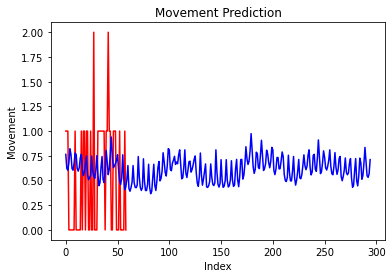

In [172]:
plt.plot(train_y, color='red', label='Real Movement')
plt.plot(predict_train, color='blue', label='Predicted')
plt.title('Movement Prediction')
plt.xlabel('Index')
plt.ylabel('Movement')